In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
import matplotlib.pyplot as plt

pd.options.display.max_rows=10
pd.options.display.float_format="{:.1f}".format
tf.keras.backend.set_floatx('float32')

e:\python 3.7.6\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
e:\python 3.7.6\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
e:\python 3.7.6\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
e:\python 3.7.6\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym

In [3]:
train_df=pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df=pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

scale_factor=1000.0

train_df["median_house_value"]/=scale_factor
test_df["median_house_value"]/=scale_factor
train_df=train_df.reindex(np.random.permutation(train_df.index))

In [4]:
feature_columns=[]
latitude=tf.feature_column.numeric_column("latitude")
feature_columns.append(latitude)

longitude=tf.feature_column.numeric_column("longitude")
feature_columns.append(longitude)

fp_feature_layer=layers.DenseFeatures(feature_columns)

In [5]:
#@title Define functions to create and train a model, and a plotting function
def create_model(my_learning_rate, feature_layer):
    model = tf.keras.models.Sequential()
    model.add(feature_layer)
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model           


def train_model(model, dataset, epochs, batch_size, label_name):
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                        epochs=epochs, shuffle=True)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    rmse = hist["root_mean_squared_error"]

    return epochs, rmse   


def plot_the_loss_curve(epochs, rmse):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")
    plt.plot(epochs, rmse, label="Loss")
    plt.legend()
    plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
    plt.show()  

print("Defined the create_model, train_model, and plot_the_loss_curve functions.")

Defined the create_model, train_model, and plot_the_loss_curve functions.


Instructions for updating:
Use `tf.cast` instead.
Epoch 1/30
17000/17000 [==============================] - 5s 310us/sample - loss: 15288.3422 - root_mean_squared_error: 123.6460s - loss: 15607.7977 - root_mean_squared_error:
Epoch 2/30
17000/17000 [==============================] - 3s 184us/sample - loss: 13455.1940 - root_mean_squared_error: 115.9965
Epoch 3/30
17000/17000 [==============================] - 3s 161us/sample - loss: 13400.6130 - root_mean_squared_error: 115.7610s - loss: 13399.5595 - root_mean_squared_error: 115.
Epoch 4/30
17000/17000 [==============================] - 3s 151us/sample - loss: 13345.0951 - root_mean_squared_error: 115.5210
Epoch 5/30
17000/17000 [==============================] - 4s 236us/sample - loss: 13302.2191 - root_mean_squared_error: 115.3353
Epoch 6/30
17000/17000 [==============================] - 3s 154us/sample - loss: 13262.5419 - root_mean_squared_error: 115.1631
Epoch 7/30
17000/17000 [==============================] - 5s 269us/sample - l

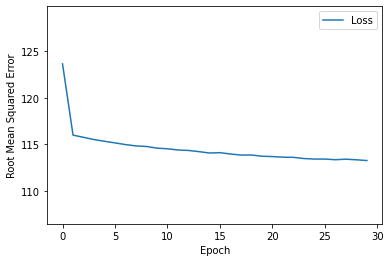


: Evaluate the new model against the test set:
3000/3000 [==============================] - 1s 183us/sample - loss: 12174.5736 - root_mean_squared_error: 110.3384


[12174.573551432291, 110.33845]

In [6]:
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'median_house_value'

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

In [11]:
resolution_in_degrees=1.0

feature_columns=[]

latitude_as_a_numeric_column=tf.feature_column.numeric_column("latitude")
latitude_boundaries=list(np.arange(int(min(train_df['latitude'])),
                                  int(max(train_df['latitude'])),
                                  resolution_in_degrees))
latitude=tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)
feature_columns.append(latitude)

#Bucket feature column for longitude.
longitude_as_a_numeric_column=tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), 
                                      int(max(train_df['longitude'])), 
                                      resolution_in_degrees))
longitude=tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries)

feature_columns.append(longitude)

buckets_feature_layer=layers.DenseFeatures(feature_columns)

Instructions for updating:
Use `tf.cast` instead.
Epoch 1/35
17000/17000 [==============================] - 3s 190us/sample - loss: 52134.1281 - root_mean_squared_error: 228.3290s - loss: 54907.9702 - root_mean_squ - ETA: 1s - loss: 53742.5459 - root_mean_squa
Epoch 2/35
17000/17000 [==============================] - 4s 215us/sample - loss: 44721.4107 - root_mean_squared_error: 211.4743
Epoch 3/35
17000/17000 [==============================] - 3s 165us/sample - loss: 38137.3601 - root_mean_squared_error: 195.2879s - loss: 39877.2648 - root_mean_squar - ETA: 0s - loss: 38779.8845 - root_mean_squared_error:
Epoch 4/35
17000/17000 [==============================] - 5s 282us/sample - loss: 32317.7353 - root_mean_squared_error: 179.7714
Epoch 5/35
17000/17000 [==============================] - 5s 322us/sample - loss: 27303.9446 - root_mean_squared_error: 165.2391
Epoch 6/35
17000/17000 [==============================] - 6s 370us/sample - loss: 23042.3856 - root_mean_squared_error: 151.7972s

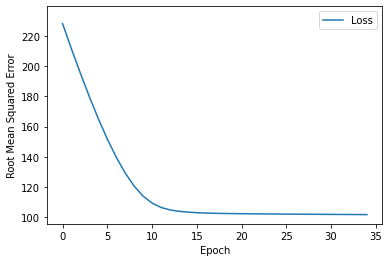


: Evaluate the new model against the test set:
3000/3000 [==============================] - 1s 168us/sample - loss: 10198.4337 - root_mean_squared_error: 100.9873


[10198.433675130209, 100.9873]

In [12]:
learning_rate=0.04
epochs=35

my_model=create_model(learning_rate, buckets_feature_layer)

epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, rmse)
print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

In [13]:
#Representing Location as a Featrue Cross.
reolution_in_degrees=1.0

feature__columns=[]

latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), int(max(train_df['latitude'])), resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), int(max(train_df['longitude'])), resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries)

latitude_x_longitude=tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature=tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

feature_cross_feature_layer=layers.DenseFeatures(feature_columns)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Epoch 1/35
17000/17000 [==============================] - 8s 469us/sample - loss: 50756.4654 - root_mean_squared_error: 225.2920
Epoch 2/35
17000/17000 [==============================] - 9s 505us/sample - loss: 41409.2334 - root_mean_squared_error: 203.4925
Epoch 3/35
17000/17000 [==============================] - 6s 347us/sample - loss: 33436.3848 - root_mean_squared_error: 182.8562
Epoch 4/35
17000/17000 [==============================] - 8s 455us/sample - loss: 26768.3052 - root_mean_squared_error: 163.6102
Epoch 5/35
17000/17000 [==============================] - 8s 482us/sample - loss: 21413.9648 - root_mean_squared_error: 146.3351
Epoch 6/35
17000/17000 [==============================] - 7s 401us/sample - loss: 17229.1347 - root_mean_sq

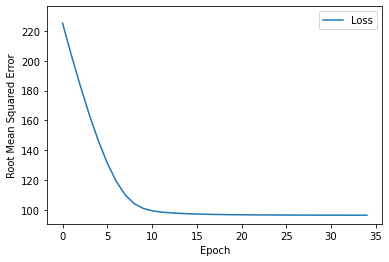


: Evaluate the new model against the test set:
3000/3000 [==============================] - 1s 221us/sample - loss: 9101.7171 - root_mean_squared_error: 95.4029


[9101.717057291668, 95.402916]

In [14]:
learning_rate=0.04
epochs=35

my_model=create_model(learning_rate, feature_cross_feature_layer)

epochs, rmse=train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)